In [1]:
from utils import *
import matplotlib.pyplot as plt


/home/roboworks/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)

In [3]:
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB) 

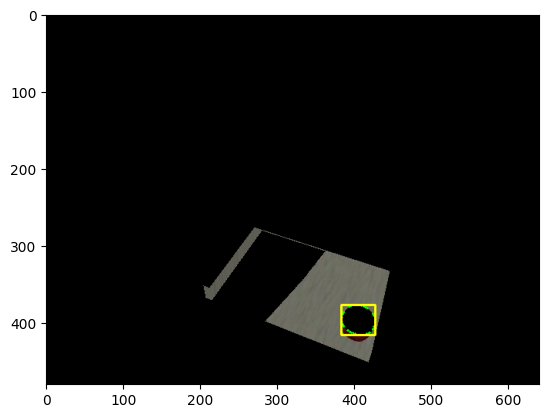

In [49]:
plt.imshow(rgb_image)

In [50]:
try:
        trans = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
                    
        trans,rot=read_tf(trans)
        #print ("############head",trans,rot)
except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
        print ( 'No head TF FOUND')
t= write_tf(trans,rot)
cloud_out = do_transform_cloud(points_msg, t)

In [51]:
np_corrected=ros_numpy.numpify(cloud_out)
corrected=np_corrected.reshape(points_data.shape)

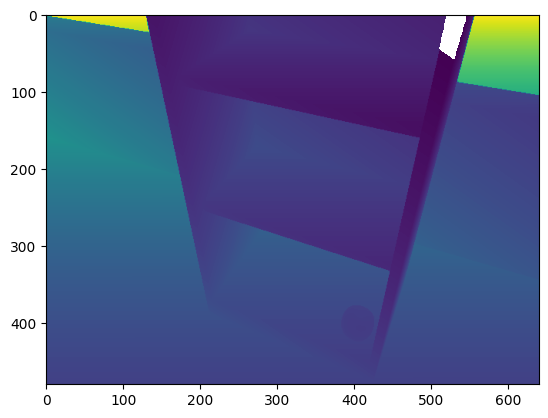

In [52]:
plt.imshow(points_data['z'])

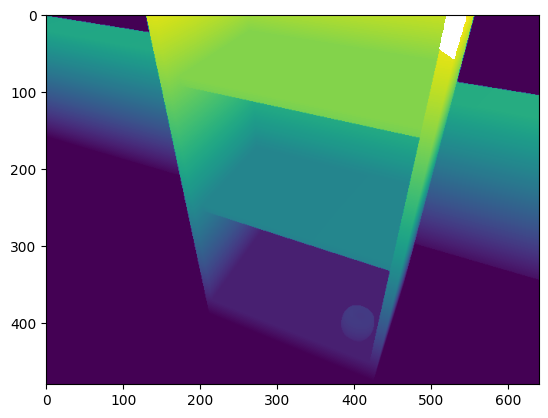

In [53]:
plt.imshow(corrected['z'])

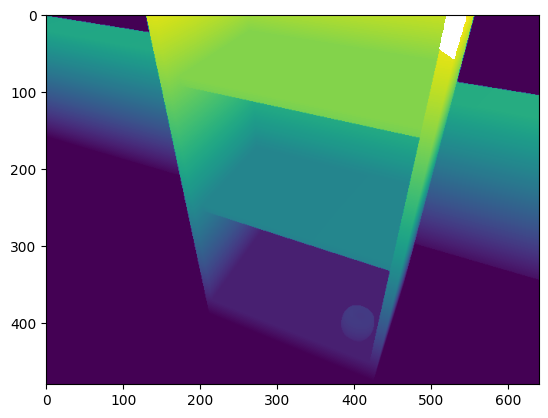

In [54]:
img_z=corrected['z']
plt.imshow(img_z)

In [55]:
lower=100
higher=10000


1307.0
0.0699044359177351
Pca.explained_variance_ [0.00244691 0.00090344 0.00010625]
[-158.58534138   -3.17108635  -88.1173673 ]


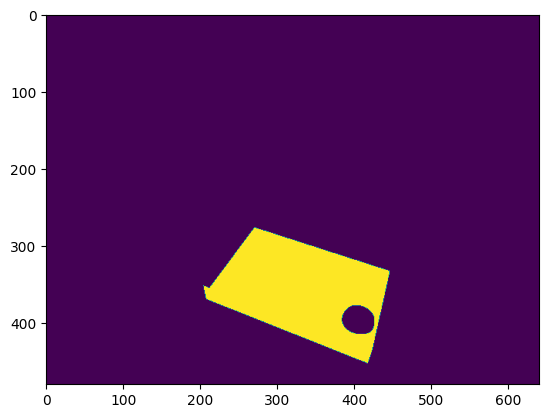

In [70]:
### MODIFICATION FOR STORING GRECIES, FINDING PLACING PLANE
orig_image= rgb_image.copy()
mask= np.zeros(corrected['z'].shape)#mask
low_plane = (corrected['z'] > 0.065) #plane height
high_plane = (corrected['z'] < 0.12)#plane height + obj height
high_x = (corrected['x'] > 7.8)
low_x = (corrected['x'] < 8.25)
#x coords placing plane limit
z_lims=np.logical_and(low_plane, high_plane)
x_lims=np.logical_and(low_x, high_x)
result_indices = np.where(np.logical_and(z_lims, x_lims))

mask[result_indices]=200
_, binary_image = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)

###############FOR DEBUG IMAGE
cv2_image = cv2.cvtColor(binary_image.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
img=cv2.bitwise_and(orig_image, cv2_image)
image_with_contours = img.copy()
#######################################

contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8) ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cents=[]
quats_pca=[]
for contour in contours:
    # Draw contours on the image
    area = cv2.contourArea(contour)    
    if area > lower and area < higher :  #### AREA IN PIXELS ( USEFUL TO AVOID WALLS OR OTHER BIG CLUSTRS)
        print(area)        
        boundRect = cv2.boundingRect(contour)
        mask = np.zeros_like(binary_image) 
        mask=cv2.rectangle(mask,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), -1)
        individual_mask=(mask*binary_image).astype(np.uint8)        
        cent=np.asarray(   ((  np.nanmean(corrected['x'][np.where(individual_mask==1)]) ,np.nanmean(corrected['y'][np.where(individual_mask==1)]),np.nanmean(corrected['z'][np.where(individual_mask==1)])       ))      )
        cents.append(cent)        
        ################################PCA
        points_c=np.asarray((corrected['x'][np.where(individual_mask==1)],corrected['y'][np.where(individual_mask==1)],corrected['z'][np.where(individual_mask==1)]))
        E_R=points_to_PCA(points_c.transpose())
        e_ER=tf.transformations.euler_from_matrix(E_R)
        quat= tf. transformations.quaternion_from_euler(e_ER[0],e_ER[1],e_ER[2])
        quats_pca.append(quat)
        print(np.rad2deg(tf.transformations.euler_from_matrix(E_R)))
        #######FOR DEBUG IMAGE
        cv2.drawContours(image_with_contours, contour, -1, (0, 255, 0), 2)  # -1 draws all contours
        rgb_image=cv2.rectangle(image_with_contours,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)

        
#plt.imshow(img)
plt.imshow (binary_image)

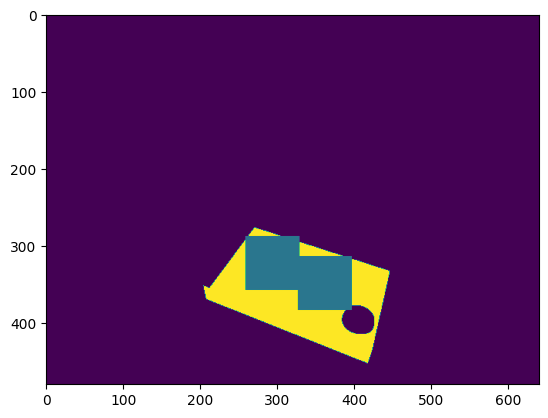

In [71]:
xs,ys=np.where(binary_image==255 )[0] ,np.where(binary_image==255 )[1]
for x,y  in zip(xs,ys):
    if np.mean(binary_image[y-35:y+35,x-35:x+35]) >250:
        binary_image[y-35:y+35,x-35:x+35]=100
plt.imshow(binary_image)


In [ ]:
np.where(binar)

1314.5
0.06994186712801456
Pca.explained_variance_ [0.00257002 0.00086022 0.00010466]
[-159.43108365   -2.09163816  -92.32735284]
2366.5
0.06992914468050003
Pca.explained_variance_ [6.8651862e-03 2.0804272e-04 3.7652322e-14]
[  90.20584568   -0.34772785 -179.69393604]
2318.5
0.06986243176460266
Pca.explained_variance_ [4.6354461e-02 2.0832564e-04 2.9357858e-13]
[-89.79356436   0.34771077 179.94142741]


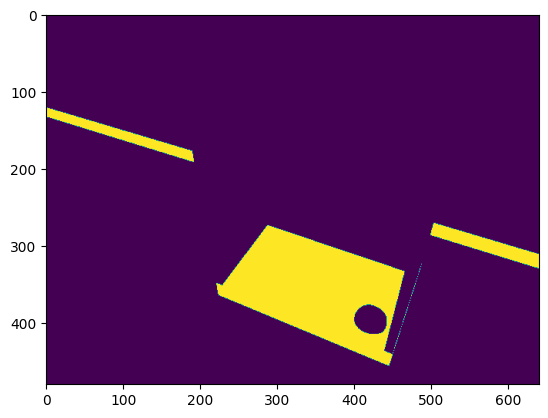

In [33]:
orig_image= rgb_image.copy()
mask= np.zeros(corrected['z'].shape)#mask
low_plane = (corrected['z'] > 0.07) #plane height
high_plane = (corrected['z'] < 0.12)#plane height + obj height
result_indices = np.where(np.logical_and(low_plane, high_plane))
mask[result_indices]=200
_, binary_image = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)

###############FOR DEBUG IMAGE
cv2_image = cv2.cvtColor(binary_image.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
img=cv2.bitwise_and(orig_image, cv2_image)
image_with_contours = img.copy()
#######################################

contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8) ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cents=[]
quats_pca=[]
for contour in contours:
    # Draw contours on the image
    area = cv2.contourArea(contour)    
    if area > lower and area < higher :  #### AREA IN PIXELS ( USEFUL TO AVOID WALLS OR OTHER BIG CLUSTRS)
        print(area)        
        boundRect = cv2.boundingRect(contour)
        mask = np.zeros_like(binary_image) 
        mask=cv2.rectangle(mask,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), -1)
        individual_mask=(mask*binary_image).astype(np.uint8)        
        cent=np.asarray(   ((  np.nanmean(corrected['x'][np.where(individual_mask==1)]) ,np.nanmean(corrected['y'][np.where(individual_mask==1)]),np.nanmean(corrected['z'][np.where(individual_mask==1)])       ))      )
        cents.append(cent)        
        ################################PCA
        points_c=np.asarray((corrected['x'][np.where(individual_mask==1)],corrected['y'][np.where(individual_mask==1)],corrected['z'][np.where(individual_mask==1)]))
        E_R=points_to_PCA(points_c.transpose())
        e_ER=tf.transformations.euler_from_matrix(E_R)
        quat= tf. transformations.quaternion_from_euler(e_ER[0],e_ER[1],e_ER[2])
        quats_pca.append(quat)
        print(np.rad2deg(tf.transformations.euler_from_matrix(E_R)))
        #######FOR DEBUG IMAGE
        cv2.drawContours(image_with_contours, contour, -1, (0, 255, 0), 2)  # -1 draws all contours
        rgb_image=cv2.rectangle(image_with_contours,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)

        
#plt.imshow(img)
plt.imshow (binary_image)

In [56]:
quats_pca, cents

([array([ 0.62326717, -0.42698881,  0.46084375,  0.46566258])],
 [array([ 2.3778174 , -0.92811584,  0.74646336], dtype=float32)])

In [57]:
#tf_map
for i, cent in enumerate(cents):
    x,y,z=cent
    axis=[0,0,1]
    angle = tf.transformations.euler_from_quaternion(quats_pca[i])[0]
    rotation_quaternion = tf.transformations.quaternion_about_axis(angle, axis)
    t=write_tf(    (x,y,z), rotation_quaternion, 'object'+str(i), "map"   )
    broadcaster.sendTransform(t)

In [58]:
for i, cent in enumerate(cents):
    x,y,z=cent
    t=write_tf(    (x,y,z), (0,0,0,1), 'ref'+str(i), "map"   )
    broadcaster.sendTransform(t)

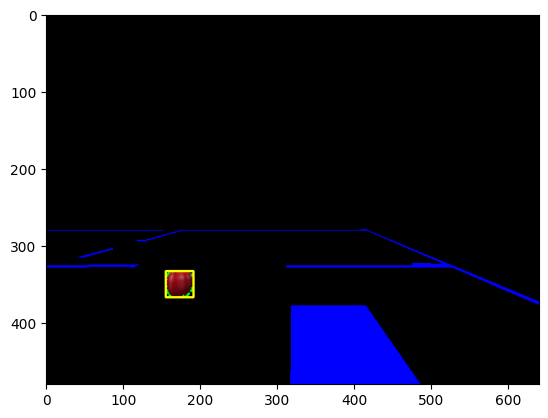

In [59]:
new= np.zeros(img_z.shape)#mask
image= rgb_image.copy()
condition1 = (img_z > 0.39)
condition2 = (img_z < 0.41)
result_indices = np.where(np.logical_and(condition1, condition2))
image[result_indices]=np.asarray((0,0,255))

#new[np.where(img_z>=0.4)]=200
condition1 = (img_z > 0.405)
condition2 = (img_z < 0.70)
result_indices = np.where(np.logical_and(condition1, condition2))
new[result_indices]=200

plt.imshow(image)

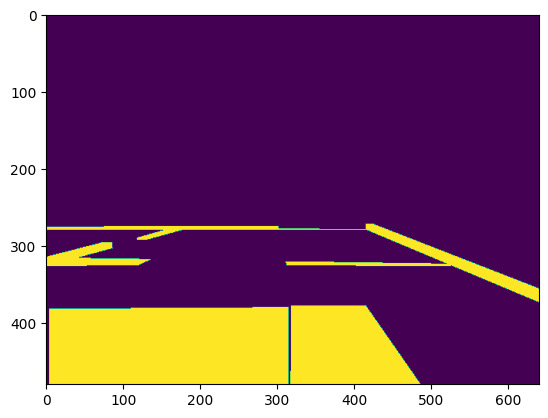

In [60]:
_, binary_image = cv2.threshold(new, 20, 255, cv2.THRESH_BINARY)
cv2_image = cv2.cvtColor(binary_image.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
plt.imshow(binary_image)

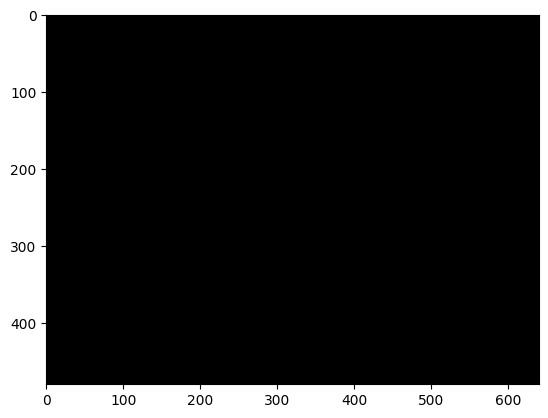

In [61]:
img=cv2.bitwise_and(rgb_image, cv2_image)
plt.imshow(img)

In [62]:
contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8) ,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

1829.5
5202.5
[array([-1.87274   ,  0.53649884,  3.946282  ], dtype=float32), array([-0.30899766,  0.53847134,  4.800477  ], dtype=float32)]


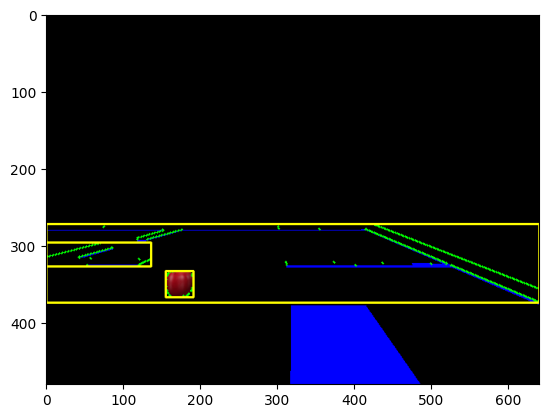

In [63]:
lower=0 
higher=10000
image_with_contours = image.copy()
len(contours)
cents=[]
points=[]
for contour in contours:
    # Draw contours on the image
    area = cv2.contourArea(contour)    
    if area > lower and area < higher :  #### AREA IN PIXELS ( USEFUL TO AVOID WALLS OR OTHER BIG CLUSTRS)
        print(area)        
        boundRect = cv2.boundingRect(contour)
        mask = np.zeros_like(binary_image) 
        mask=cv2.rectangle(mask,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), -1)
        individual_mask=(mask*binary_image).astype(np.uint8)        
        cent=np.asarray(   ((  np.nanmean(points_data['x'][np.where(individual_mask==1)]) ,np.nanmean(points_data['y'][np.where(individual_mask==1)]),np.nanmean(points_data['z'][np.where(individual_mask==1)])       ))      )
        cents.append(cent)
        cv2.drawContours(image_with_contours, contour, -1, (0, 255, 0), 2)  # -1 draws all contours
        rgb_image=cv2.rectangle(image_with_contours,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)
plt.imshow (image_with_contours)
print (cents)

In [64]:
for i, cent in enumerate(cents):
    x,y,z=cent
    t=write_tf(    (x,y,z), (0,0,0,1), 'object'+str(i), "head_rgbd_sensor_rgb_frame"   )
    broadcaster.sendTransform(t)

         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp


In [9]:
zs_no_nans=corrected['z'][~np.isnan(corrected['z'])]
histogram, bin_edges =(np.histogram(zs_no_nans, bins=100))
plane_height= bin_edges[histogram[:-1].argmax()]
print (plane_height)

0.39569223


         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/r

In [66]:
hist,bins=np.histogram()])
plt.hist(img_z,bins=bins)

SyntaxError: unmatched ']' (3516110884.py, line 1)

In [24]:
counts, bins =(np.histogram(zs_no_nans, bins=50))
inds=np.where(counts>5000)
low_planes_height=bins[np.add(inds, 1)].flatten()

low_planes_height2=bins[inds]

In [28]:
low_planes_height2.shape

(10,)

In [16]:
 np.add(inds, 1)

array([[ 1, 19, 20, 21, 22, 23, 24, 25, 26, 39]])

         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp


Number of planes found 3 at z=[[0.00445246 0.39869145 0.7001683 ]]


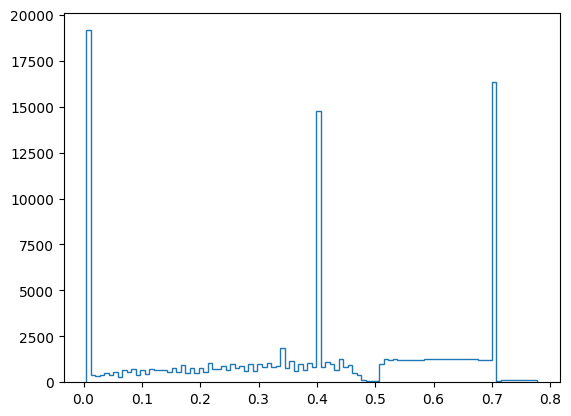

In [67]:
zs_no_nans=corrected['z'][~np.isnan(corrected['z'])]
counts, bins =(np.histogram(zs_no_nans, bins=100))
inds=np.where(counts>5000)
print (f'Number of planes found {len(inds[0])} at z=[{bins[inds]}]')
plt.stairs(counts, bins)


In [34]:
np.where(counts>5000)

(array([ 0, 90]),)

         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/r

         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/r

         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/r

         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp
         at line 278 in /tmp/binarydeb/ros-noetic-tf2-0.7.6/src/buffer_core.cpp


In [ ]:
bins[np.where(counts>10000)]

In [ ]:
condition1 = (img_z > 0.4)
condition2 = (img_z < 0.402)

result_indices = np.where(np.logical_or(condition1, condition2))


In [ ]:
new[np.where(img_z<=.002)]=200
new[result_indices]=100

In [ ]:
plt.imshow(new)

In [ ]:
points_c=np.asarray((corrected['x'][np.where(individual_mask==1)],corrected['y'][np.where(individual_mask==1)],corrected['z'][np.where(individual_mask==1)]))
points_c.shape
E_R=points_to_PCA(points_c.transpose())
print(np.rad2deg(tf.transformations.euler_from_matrix(E_R)))

In [85]:
result_indices=()
for plane_height in bins[inds]:
    low_plane_ix = (corrected['z'] > plane_height)
    high_plane_ix = (corrected['z'] > plane_height + 0.3)

    result_indices += np.where(np.logical_or(low_plane_ix, high_plane_ix))

    print (plane_height )

0.004452462
0.39869145
0.7001683


In [86]:
len(result_indices[0])

126516

In [71]:

high_plane = (corrected['z'] < 0.99)
result_indices = np.where(np.logical_and(low_plane, high_plane))
result_indices

(array([333, 333, 333, ..., 366, 366, 366]),
 array([165, 166, 167, ..., 175, 176, 177]))

In [90]:
 bins[inds].shape

(3,)

In [97]:
low_planes= bins[inds]

In [98]:
for lp in low_planes:
    print (lp)

0.004452462
0.39869145
0.7001683


In [100]:
low_plane = (corrected['z'] > 0.7)      # HEIGHT REQUESTED OR OBTAINED FROM HISTOGRAM
high_plane = (corrected['z'] < 0.7+.3)

In [103]:
type(low_planes)

numpy.ndarray